# Sheet 2

Jacob Waßelewsky, Johannes Schmidt, Dominik Geng

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

## 1 Kernel Density Estimation
(a)

In [5]:
def biweight(x, mu, w):
    """biweight kernel at mean mu, with bandwidth w evaluated at x"""
    if (x - mu > -w) and (x - mu < w):         # more elegant with mask with mask
        k = 15/(16*w) * (1 - ((x-mu)/w)**2)**2
    else:
        k = 0
    return k
    #TODO: implement the quartic (biweight) kernel


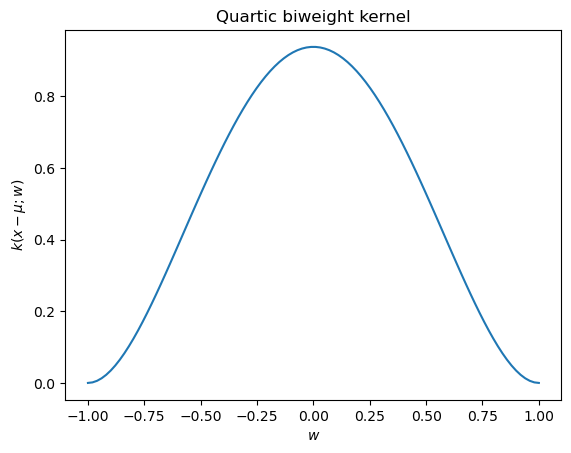

In [6]:
mu = 0
w = 1
domain = np.linspace(-1,1,num = 100)
kernel_vals = [biweight(x, mu, w) for x in domain]
plt.plot(domain, kernel_vals)
plt.ylabel(f'$k(x-\mu;w)$')
plt.xlabel(f'$w$')
plt.title('Quartic biweight kernel');
# TODO plot the kernel

We can see a symmetric kernel with support $[-1,1]$.

(b)

In [7]:
# load the data
data = np.load("data/samples.npy")
data50 = data[:50]
print(f'{data.shape=}, {data50.shape=}')

data.shape=(10000,), data50.shape=(50,)


In [8]:
x_ = data50[4] # example x
x_ - data50
print('The result is broadcasted: \n x-data50 = ', x_-data50)

kde_ = 0
for x in data50:
    kde_ += biweight(x_ - x, mu = 0, w = 1)

The result is broadcasted: 
 x-data50 =  [ 0.956057    6.83620095  0.1527347  -0.16022261  0.          0.91014681
  7.4293298   0.51493953  6.60292255  0.44825482  8.14906403  5.97400304
  7.64591618  0.33843258  5.23943767  5.93484453  0.79503942  0.98899981
  0.63264979 -0.525491    0.86387563 -2.89483556  0.01106935  0.90581603
  6.81518695  6.0118808   6.7721106   5.7250845   7.12435507  7.38703073
 -1.49370655  8.50471502  7.33714949  7.53958145  1.10249879  6.40101085
  1.07391179  1.05302318  6.83940263  6.34695325  0.92471502  0.55073825
  7.62067136  7.2868227   7.01518574 -1.11829306 -0.1610926  -8.74403715
  8.15152502  1.02399578]


In [7]:
def kde(x, obs, w=1):
    s = 0
    for o in obs:
        s += biweight(x, mu = o, w = w)
    p_x_obs = 1/(len(obs)) * s
    return p_x_obs
    # TODO: implement the KDE with the biweight kernel
    
    # or easier
    # np.mean([biweight(x, d, w) for d in obs])

Text(0, 0.5, '$kde$')

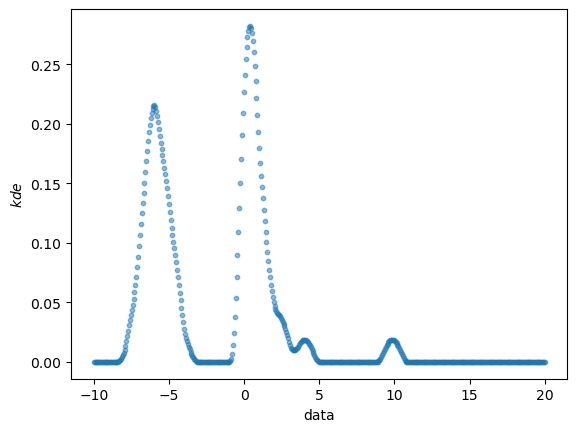

In [8]:
# TODO: compute and plot the kde on the first 50 data points
domain = np.linspace(-10, 20, 500 )
kde_50 = [kde(x, data50) for x in domain]
plt.scatter(domain, kde_50, s=10, alpha=0.5)
plt.xlabel('data')
plt.ylabel('$kde$')

Text(0.5, 1.0, 'KDE for all data points')

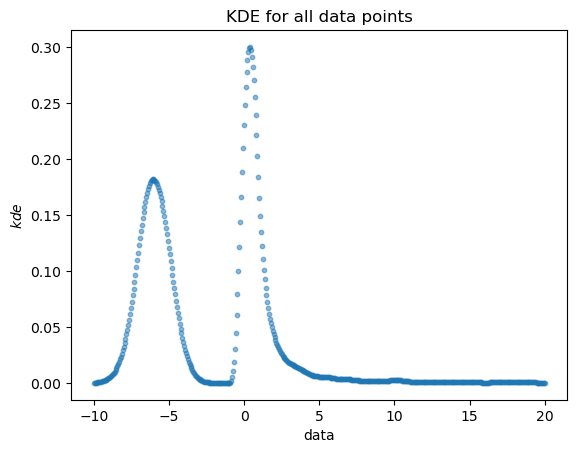

In [9]:
# TODO: explore what happens when you increase the number of points
kde_full = [kde(x, data) for x in domain]
plt.scatter(domain, kde_full, s=10 , alpha=0.5)
plt.xlabel('data')
plt.ylabel('$kde$')
plt.title('KDE for all data points')

When sampling more data points, we "get rid" of some peaks, that might have been overestimated with less data.

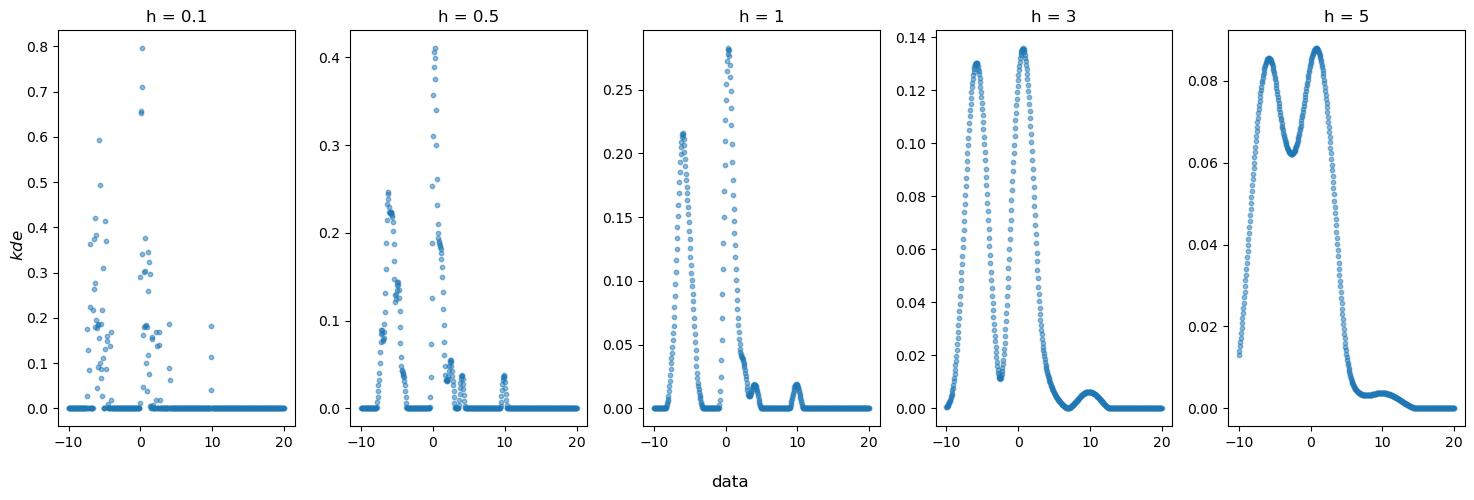

In [14]:
bands = [0.1, 0.5, 1, 3, 5]


fig, axs = plt.subplots(1, 5, figsize=(15,5))
fig.supxlabel('data')
fig.supylabel('$kde$')
for bandw, ax in zip(bands, axs):
    kde_50 = [kde(x, data50, w = bandw) for x in domain]
    ax.scatter(domain, kde_50, s=10, alpha=0.5)
    ax.set_title(f'h = {bandw}')
plt.tight_layout()

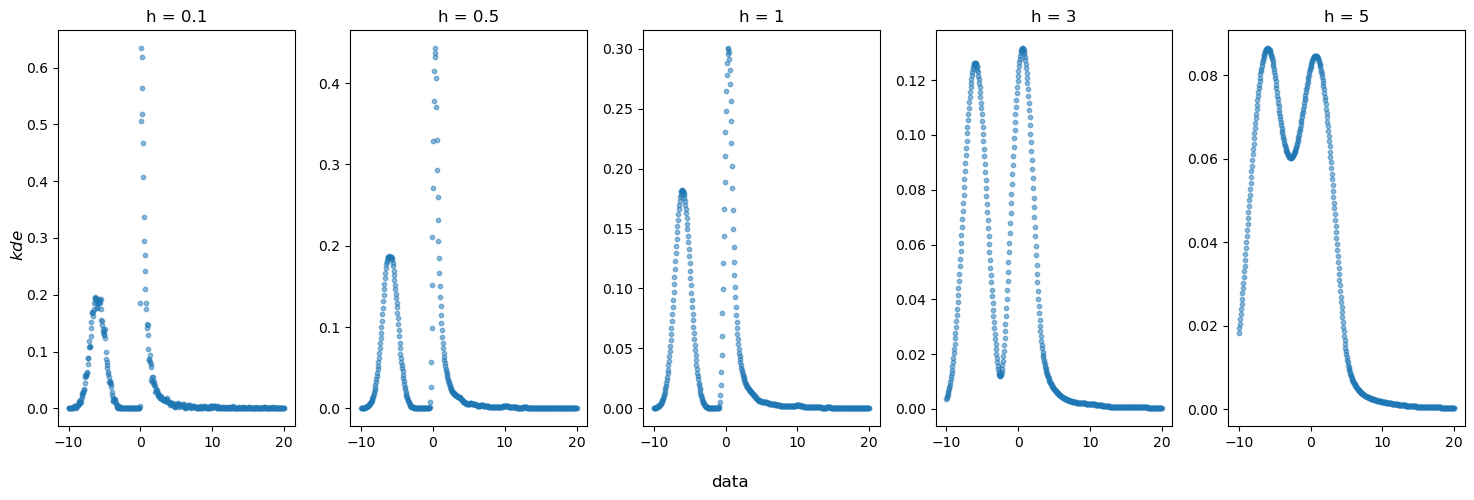

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(15,5))
fig.supxlabel('data')
fig.supylabel('$kde$')
for bandw, ax in zip(bands, axs):
    kde_list = [kde(x, data, w = bandw) for x in domain]
    ax.scatter(domain, kde_list, s=10, alpha=0.5)
    ax.set_title(f'h = {bandw}')
plt.tight_layout()

We see, that with greater bandwidth, the distribution becomes broader and peaks less distinct.  

## 3 Mean-Shift
(b) Bonus

In [51]:
# TODO: implement the update to the local mean

def mean_shift_step(x, xt, r=1):
    """
    A single step of mean shift,
    moving every point in xt to the local mean of points in x within a radius of r.
    
    Parameters
    ----------
    x : np.ndarray
        Array of points underlying the KDE, shape (d, N1)
    xt : np.ndarray
        Current state of the mean shift algorithm, shape (d, N2)
    r : float
        The radius inside of which to compute the local mean in        
    Returns
    -------
    np.ndarray
        the points after the mean-shift step
    """
    # NOTE: For the excercise you only need to implement this for d == 1. 
    #       If you want some extra numpy-practice, implement it for arbitrary dimension
    
    assert xt.shape[0] == x.shape[0], f'Shape mismatch: {x.shape[0]}!={xt.shape[0]}'
    
    # TODO: compute a N by N matrix 'dist' of distances, 
    #       such that dists[i, j] is the distance between x[i] and xt[j]
    #dist = x[:,None] - xt[None, :]
    offsets = x[:,:,None] - xt[:, None, :] # (d, N1, N2) = (d, N1, 1) - (d, 1, N2)
    dists = np.linalg.norm(offsets, axis=0)
    # TODO: threshold the distances with r to get an array of masks for every data point
    #mask = np.abs(dist)<r
    mask = dist < r
    # TODO: compute the number of points in x within radius r of each xt
    # num = mask.sum(axis=1)
    num = mask.sum(0)
    # TODO: compute the local means by summing over the neighbors of each element in xt 
    #       and dividing by the number of neighbors
    #neighbors = np.where(mask, dist, 0) # keep the values where the distances are smaller than 1
                                        # and set to 0 otherwise
    #local_means = neighbors.sum(axis=1) / (num + 10e-12) # to avoid divide by 0
    local_means = (masks[None] * x[:, :, None]).sum(1) / n_neighbros[None]
    return local_means
    

In [231]:
mask = np.abs(dist) < 1

num = mask.sum(axis=1)

num # number of distances in the region (the query point itself also counted)

array([81, 63, 92, 62, 78, 81, 61, 86, 61, 89, 40, 37, 59, 89, 17, 37, 83,
       81, 85, 30, 81,  4, 80, 81, 63, 37, 63, 29, 61, 64, 13, 32, 65, 61,
       78, 52, 78, 79, 63, 50, 81, 86, 59, 64, 62, 17, 62,  1, 40, 79, 83,
       53, 79, 92, 44, 25, 85, 37, 83, 85, 48,  1, 39, 51, 40, 89, 40, 34,
       24, 43, 79, 40,  3, 62, 64,  3, 23, 81, 39, 85, 83, 63, 61, 61, 63,
       48, 80, 62, 63, 87, 83, 61, 86, 61, 85, 53, 53, 85, 85, 89, 89, 81,
       85, 40, 78, 55, 85, 89, 80, 85, 85, 28, 92, 81, 60,  7, 63, 63, 83,
       79, 83, 88, 47, 50, 85, 79, 37, 85, 89, 81, 79,  3, 40, 29, 57, 86,
       85, 65, 14, 29,  1, 86, 83, 48, 15, 81, 62,  8, 61, 22, 64, 79, 16,
       22, 81, 22, 85, 61, 63, 81, 37, 59, 37, 63, 61, 85, 85, 47,  8, 64,
       86, 48, 81, 65, 61, 31, 63,  3,  6, 78, 12, 51, 85, 81, 51, 86,  8,
       55, 55, 92, 85, 51, 88,  9, 60,  8, 81, 61, 61, 81])

In [205]:
np.where(mask, dist, 0).sum(axis=1) / num

array([-0.24217402,  0.05549711,  0.42048123,  0.50457376,  0.48798168,
       -0.19626383, -0.03270895,  0.14337705,  0.16728445,  0.17047473,
       -0.29574005,  0.29696566, -0.15369357,  0.28029698,  0.51446545,
        0.33612417, -0.10222971, -0.27511682,  0.03823291,  0.30790635,
       -0.14999265,  0.60359206,  0.48980786, -0.19193304,  0.04487255,
        0.2590879 ,  0.08794889,  0.39881748,  0.02372859, -0.03655209,
        0.31895061, -0.41054444, -0.03275787, -0.11010634, -0.36211083,
        0.20366753, -0.33352383, -0.32120732,  0.05229543,  0.22632523,
       -0.21083204,  0.10757833, -0.12844875, -0.02958995,  0.02005698,
        0.28055434,  0.50544375,  0.        , -0.29820104, -0.29217992,
       -0.09832233,  0.21086807, -0.28166573,  0.46127866,  0.29434857,
       -0.31620516,  0.00471461,  0.39028528, -0.11827759, -0.03872234,
       -0.3006244 ,  0.        , -0.40019196, -0.31534136, -0.27572628,
        0.29372729,  0.29775388,  0.39405578, -0.39327304,  0.28

In [235]:
%%timeit
dist = (x[:,None] - x[None, :]) # flexing with our vectorization skills

33.4 µs ± 459 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [76]:
%%timeit
dist = np.zeros((len(x), len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        dist[i,j] = x[i]-x[j]

13.2 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [236]:
mask = dist<1
num = mask.sum(axis=1)

dist[0][2] +x[2] - x[0] # checking if dist_i,j is really x_i - x_j

0.0

In [52]:
# load the data
data = np.load("data/samples.npy")
x = data[:200]  # use e.g. the first 200 points
xt = x

trajectories = [xt]
max_steps = 100
for step in range(max_steps):
    
    # TODO: update xt with your mean shift step
    xt = mean_shift_step(x, xt)
    #xt = mean_shift_step(x[None], x[None])
    trajectories.append(xt)
    if np.allclose(trajectories[-1], trajectories[-2]):  # break in case of convergence
        break
trajectories = np.stack(trajectories)
n_steps = len(trajectories) - 1

# TODO: plot the trajectories
plt.scatter(np.arange(n_steps), trajectories[1:,100])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

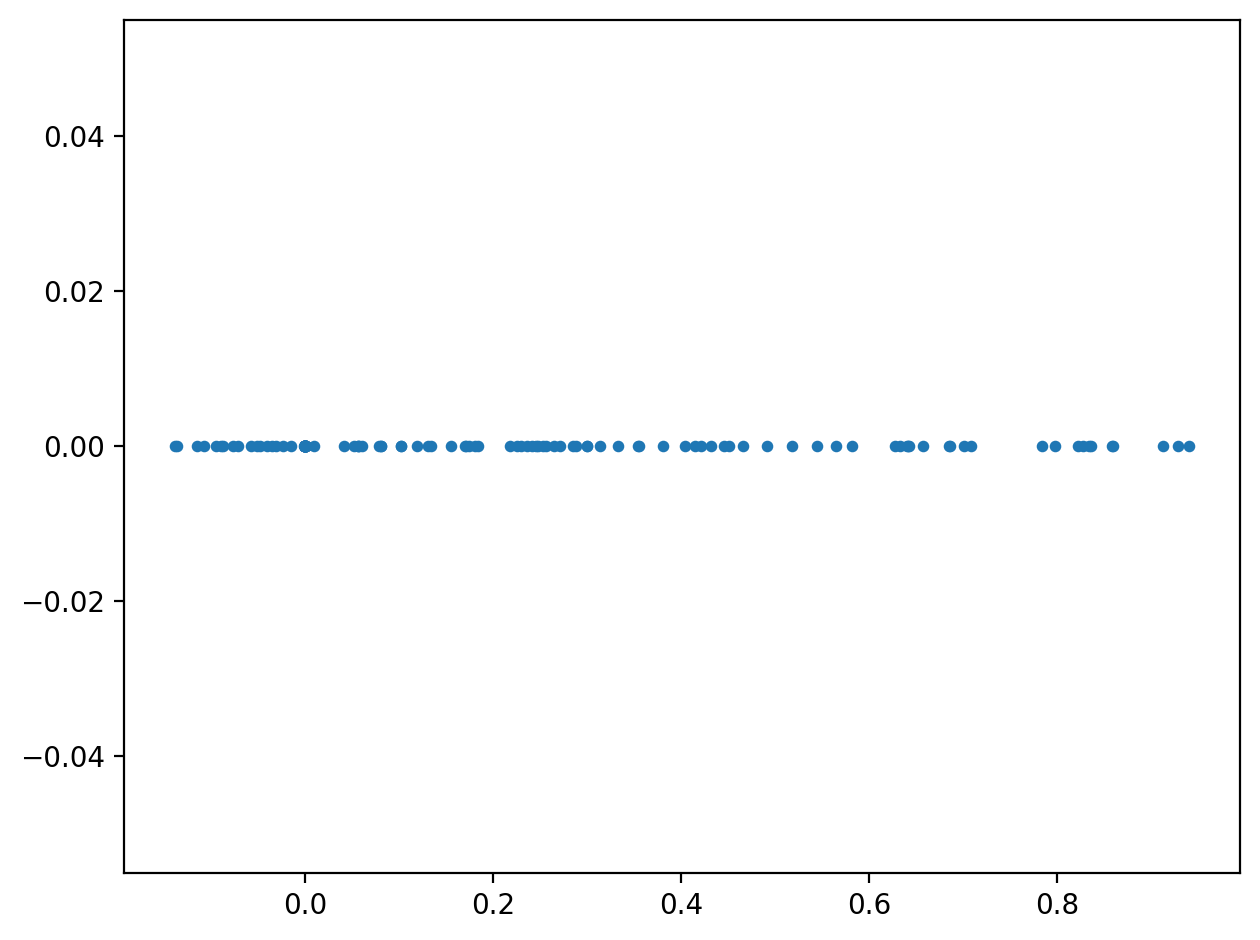

In [48]:
plt.figure(dpi=200)
plt.scatter(trajectories[-1], np.zeros((np.shape(trajectories[-1]))), s=10)
plt.tight_layout()

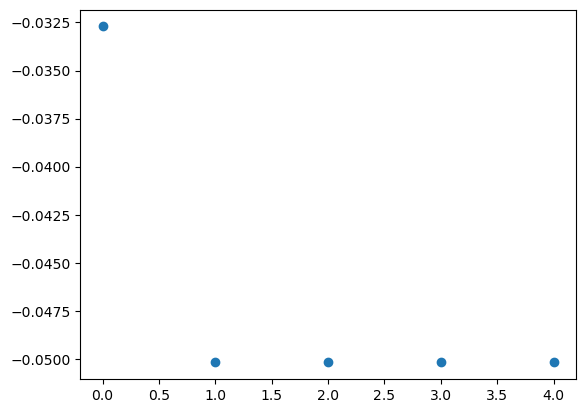

In [49]:
# TODO: repeat the above for "blurring" mean shift

x = data[:200]  # use e.g. the first 200 points
xt = x

trajectories = [xt]
max_steps = 100
for step in range(max_steps):
    
    # TODO: update xt with your mean shift step
    xt = mean_shift_step(xt, xt) # now xt is used in the update step
    trajectories.append(xt)
    if np.allclose(trajectories[-1], trajectories[-2]):  # break in case of convergence
        break
trajectories = np.stack(trajectories)
n_steps = len(trajectories) - 1

# TODO: plot the trajectories
plt.scatter(np.arange(n_steps), trajectories[1:,6])


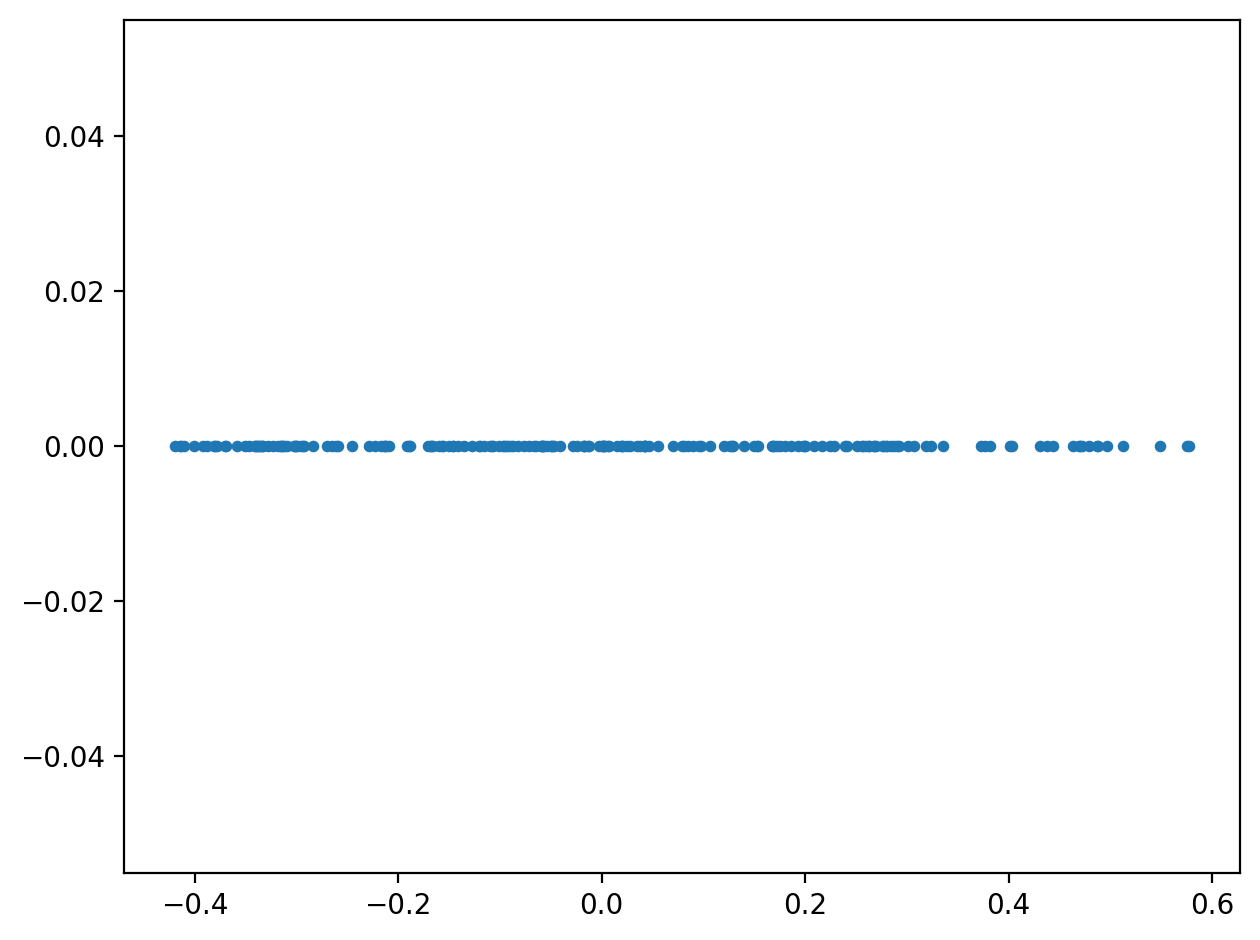

In [230]:
plt.figure(dpi=200)
plt.scatter(trajectories[-1], np.zeros((np.shape(trajectories[-1]))), s=10)
plt.tight_layout()

When we "blurr" the dataset, the calculation converges much faster and seems to build different clusters, in particular less of them.

## 4 K-Means

(b)

In [40]:
from sklearn.cluster import KMeans

def kmeans_step(x, k, c=None, init='random'):
    """
    K-Means clustering on a p x N data matrix.
    
    Parameters
    ----------
    x : np.ndarray
        Data matrix of shape (p, N).
    k : int
        Number of cluster.
    c : np.ndarray, optional
        Current cluster centers. If None, the initialization as specified by 'init' will be used.
    init: str
        The initialization method to be used if c is None.
        
    Returns
    -------
    float, np.ndarray
        cost after the step, updated cluster centers
    """
    
    if c is not None: 
        assert c.shape[1] == k
        
    # Note: the documentation is your friend: 
    #       https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    
    # TODO: set n_cluster, init, n_init and max_iter appropriately
    single_step_kmeans = KMeans(
        n_clusters=k, 
        init= init if c is None else c.T, 
        max_iter=1,
        n_init=1,
    )
    
    # TODO call the single_step_kmeans
    single_step_kmeans.fit(x.T)
    # TODO get the current energy (you don't have to compute it - it's stored in single_step_kmeans)
    E = single_step_kmeans.inertia_
    
    # TODO read out cluster centers 
    c = single_step_kmeans.cluster_centers_.T # (n_clusters, n_features)
    
    return E, c 
    

In [38]:
# load the data (you can try both with the full normalized feature and the 2d umap projection)

features = np.load('data/dijet_features_normalized.npy')  # full features
# features = np.load('data/dijet_features_umap.npy')      # umap projection

print(f'{features.shape=}')

features.shape=(116, 2233)


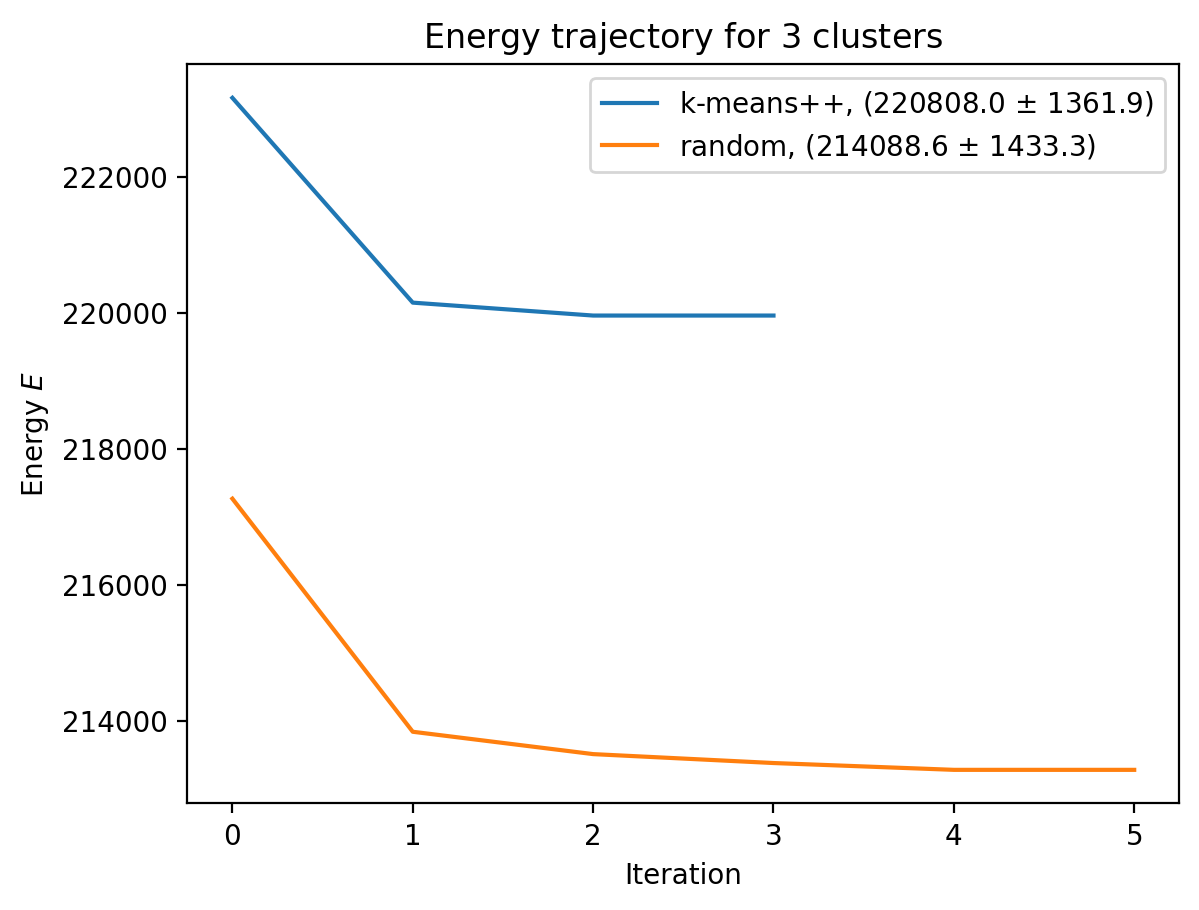

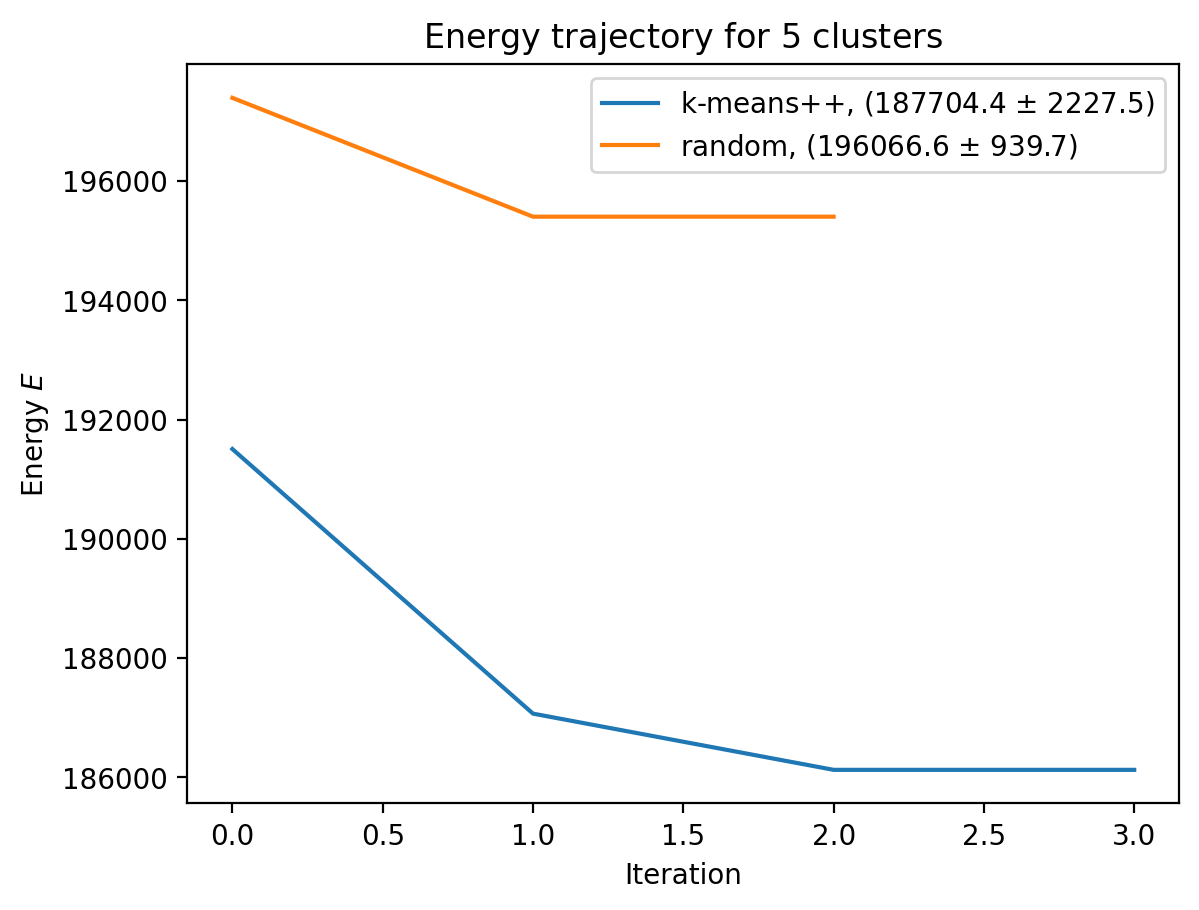

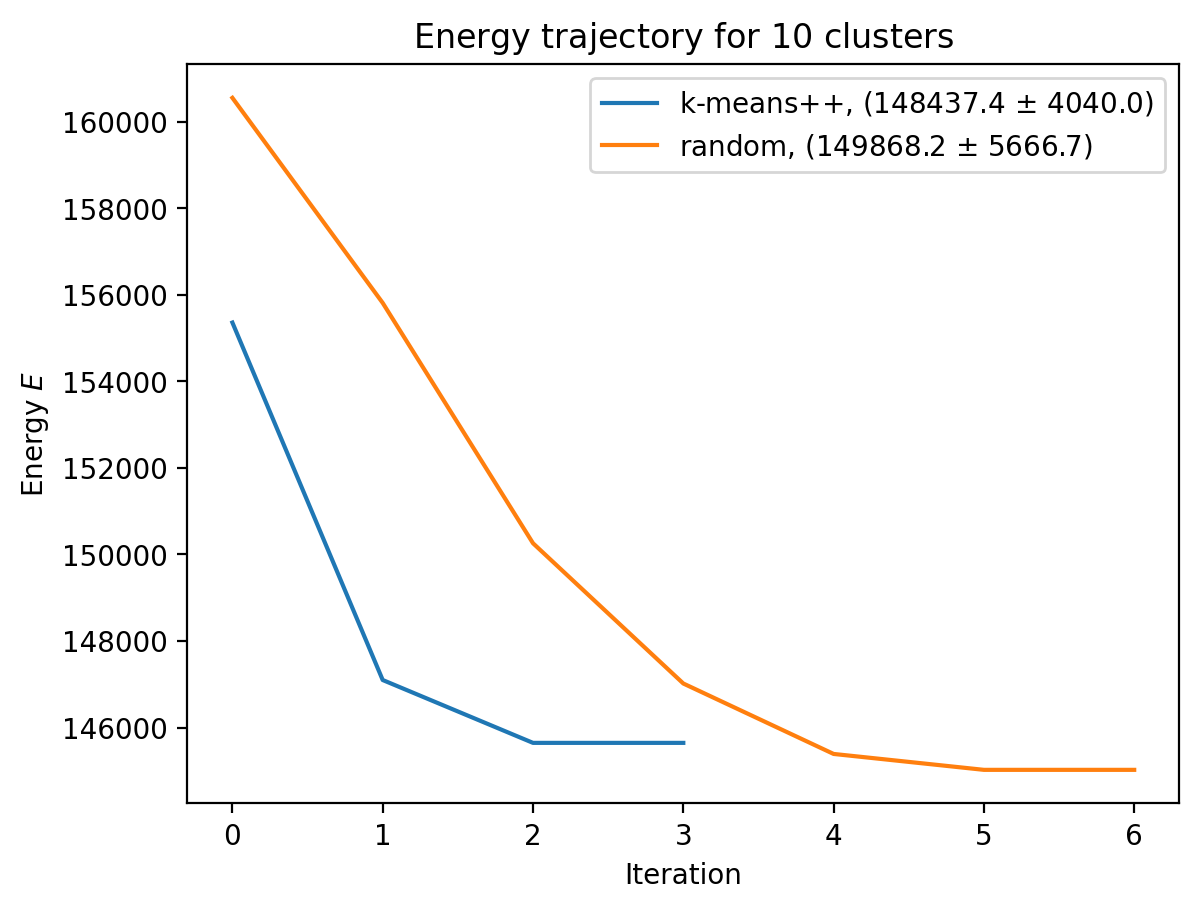

/var/folders/hw/19lr0sdd3gs7l_vcxrqh9drm0000gn/T/ipykernel_59099/3903367925.py:39: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  single_step_kmeans.fit(x.T)


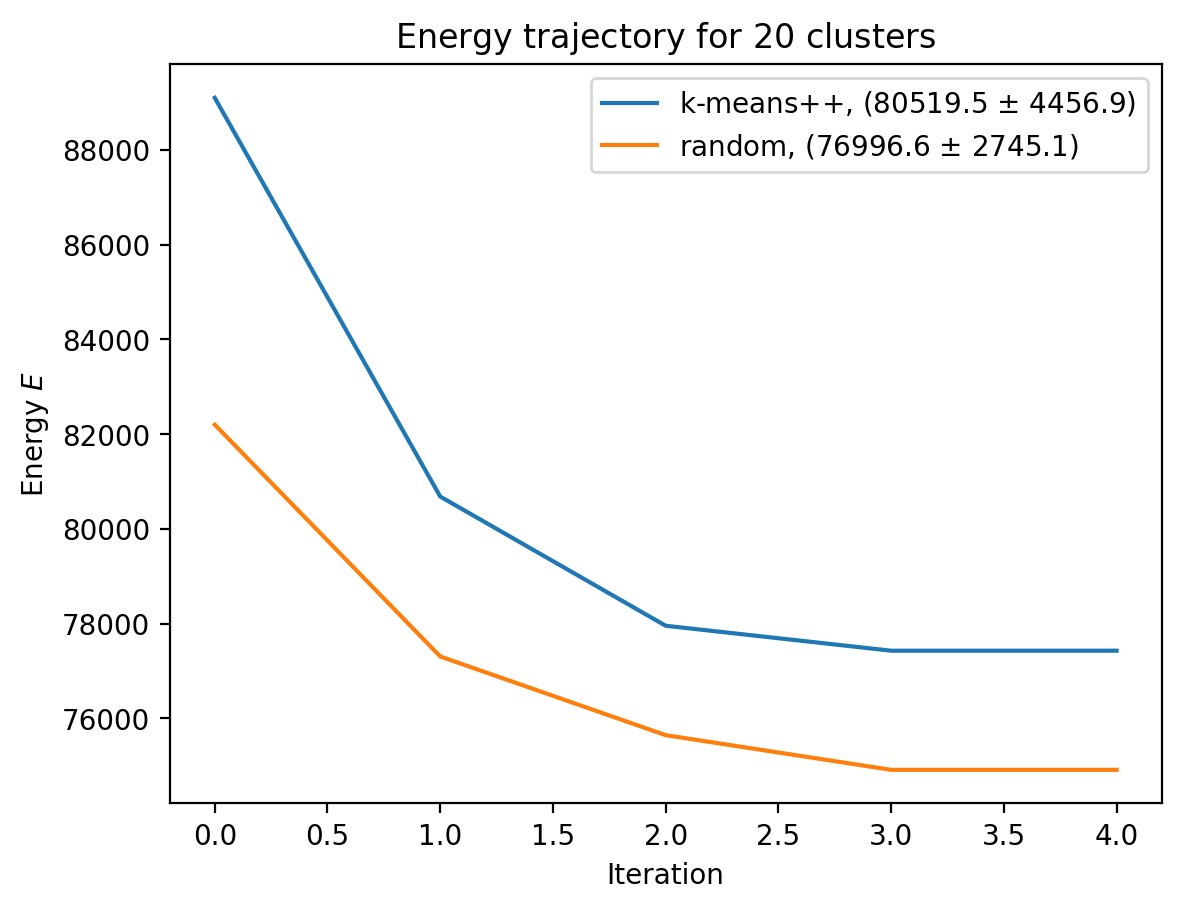

In [43]:
def kmeans(x, k, max_steps=100, init='random', early_stopping = True):
    c = None
    energies = []  # list of energies over the iterations. 
    for i in range(max_steps):
        # Call the kmeans_step implemented above to get the energy and the next cluster centers
        E, c = kmeans_step(x, k=k, c=c, init=init)
        energies.append(E)
        
        # Stop the loop if there was no improvement
        if early_stopping: # Only early stopping, when we specify it
            if i>=2 and energies[-1] == energies[-2]:
                break
    energies = np.array(energies)
    return energies  # return array of energies

steps = 50
for k in [3, 5, 10, 20]:
    plt.figure(dpi=200)
    plt.title(f'Energy trajectory for ${k}$ clusters')
    plt.xlabel('Iteration')
    plt.ylabel('Energy $E$')
    for init in ['k-means++', 'random']:
        # TODO: for the given k and init, run k-means 20 times or more (using the kmeans function above)
        #       and plot the resulting energy trajectores
        ergs = kmeans(features.T, k, steps)
        plt.plot(ergs, label = f"{init}, ({round(np.mean(ergs), 1)} $\pm$ {round(np.std(ergs), 1)})")
        plt.legend()
    plt.show()

Overall, the energy decreases with a greater number of clusters. Regarding the formula for $E$, this makes sense: The more clusters we have, the more likely it is for a data point to be well represented by a cluster mean. This takes its extreme, when we assume as many cluster centers as data points, where cluster centers will converge to the individual data points. Therefore, $E$ is no reasonable metric to minimize in order to obtain an optimal number of clusters $k$ (Luckily,<code>sklearn</code> already warns us, that "the number of disting clusters is found smaller than the number of specified clusters"). We'll illustrate this in the following plot.  <br>
Apart from that, we do not really see any initialization to reliably perform better.

ValueError: n_samples=116 should be >= n_clusters=2233.

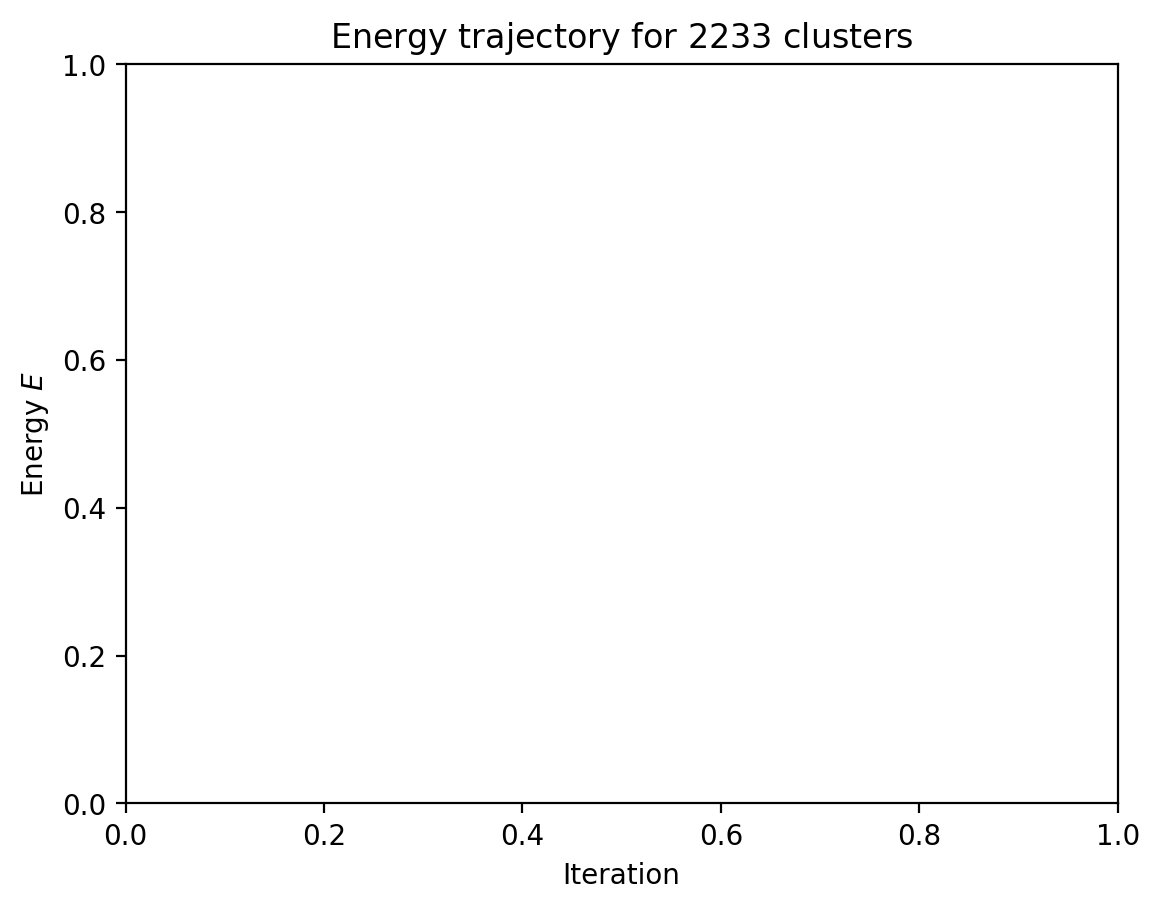

In [44]:
steps = 20
k = len(features.T)
plt.figure(dpi=200)
plt.title(f'Energy trajectory for ${k}$ clusters')
plt.xlabel('Iteration')
plt.ylabel('Energy $E$')
for init in ['k-means++', 'random']:
    # TODO: for the given k and init, run k-means 20 times or more (using the kmeans function above)
    #       and plot the resulting energy trajectores
    ergs = kmeans(features.T, k, steps, early_stopping=False)
    plt.plot(np.arange(steps), ergs, label = f"{init}, ({round(np.mean(ergs), 1)} $\pm$ {round(np.std(ergs), 1)})")
    plt.legend()
plt.show()

We'll now do the same for the <code>UMAP</code> data.

In [49]:
features = np.load('data/dijet_features_umap.npy')      # umap projection

print(f'{features.shape=}')

features.shape=(2, 2233)


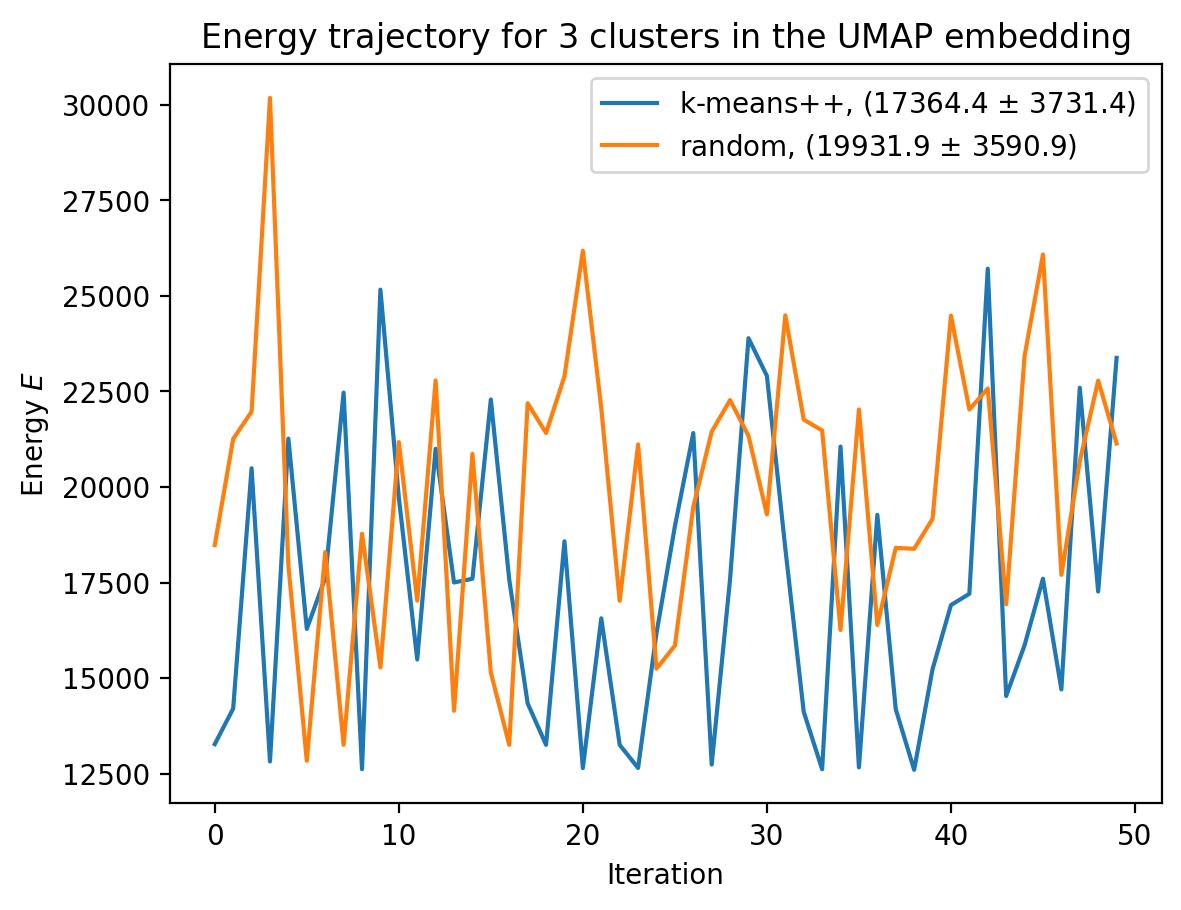

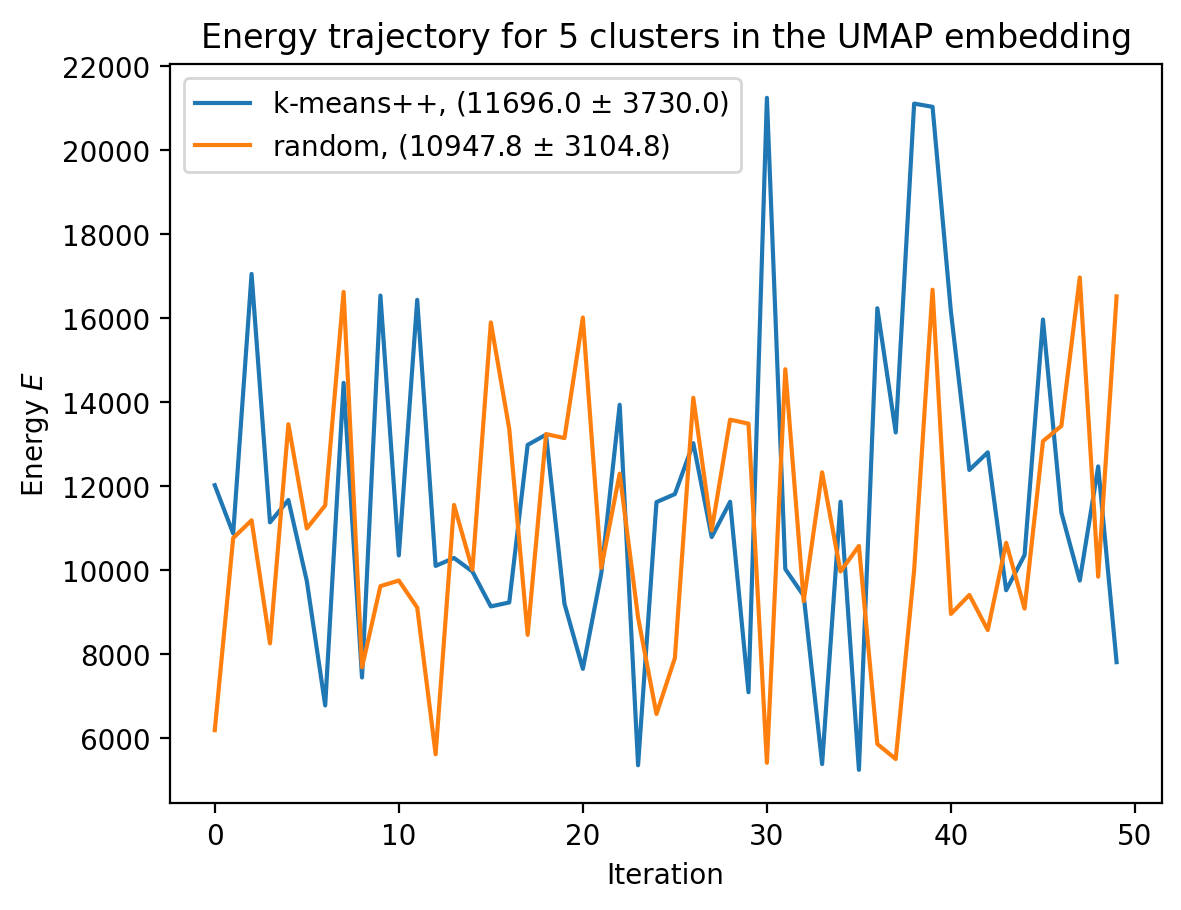

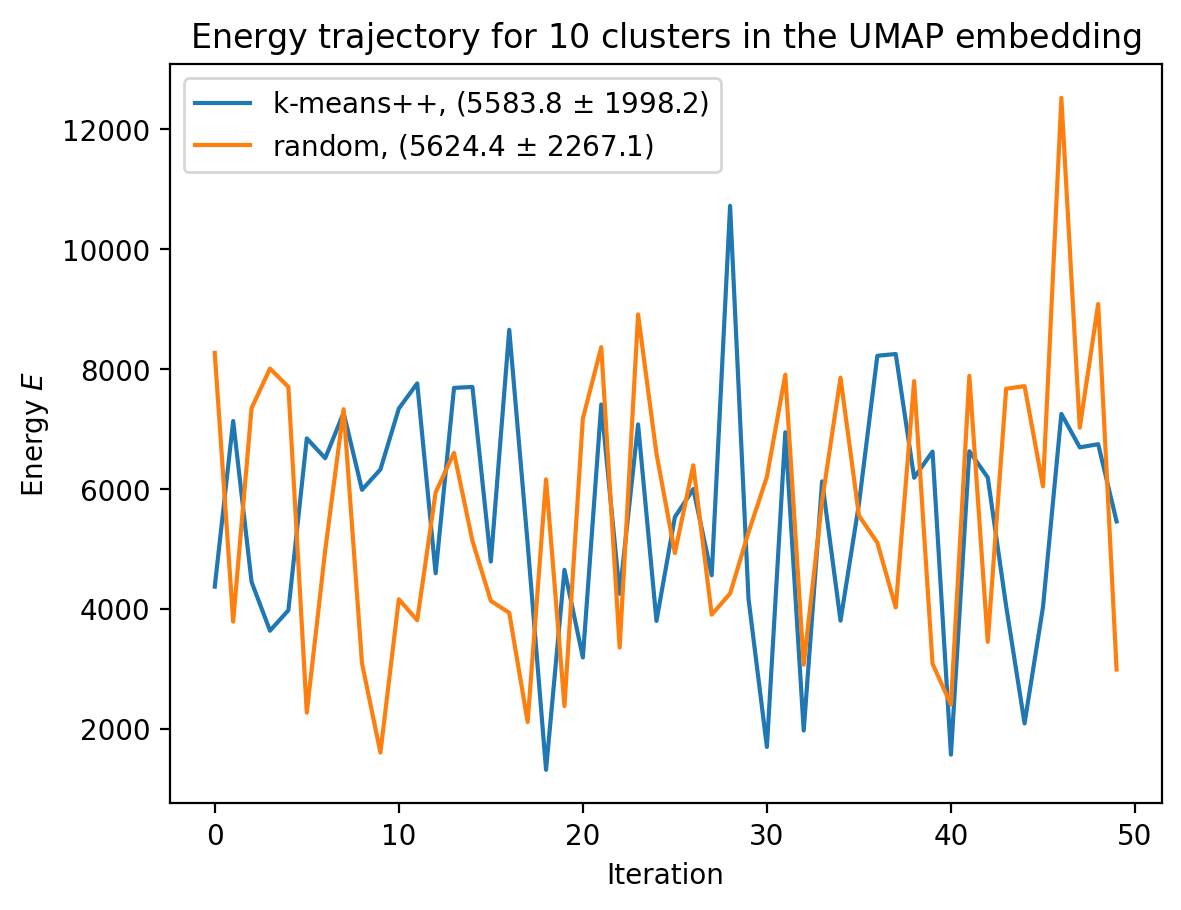

/var/folders/hw/19lr0sdd3gs7l_vcxrqh9drm0000gn/T/ipykernel_51645/1854346151.py:39: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans = single_step_kmeans.fit(x)


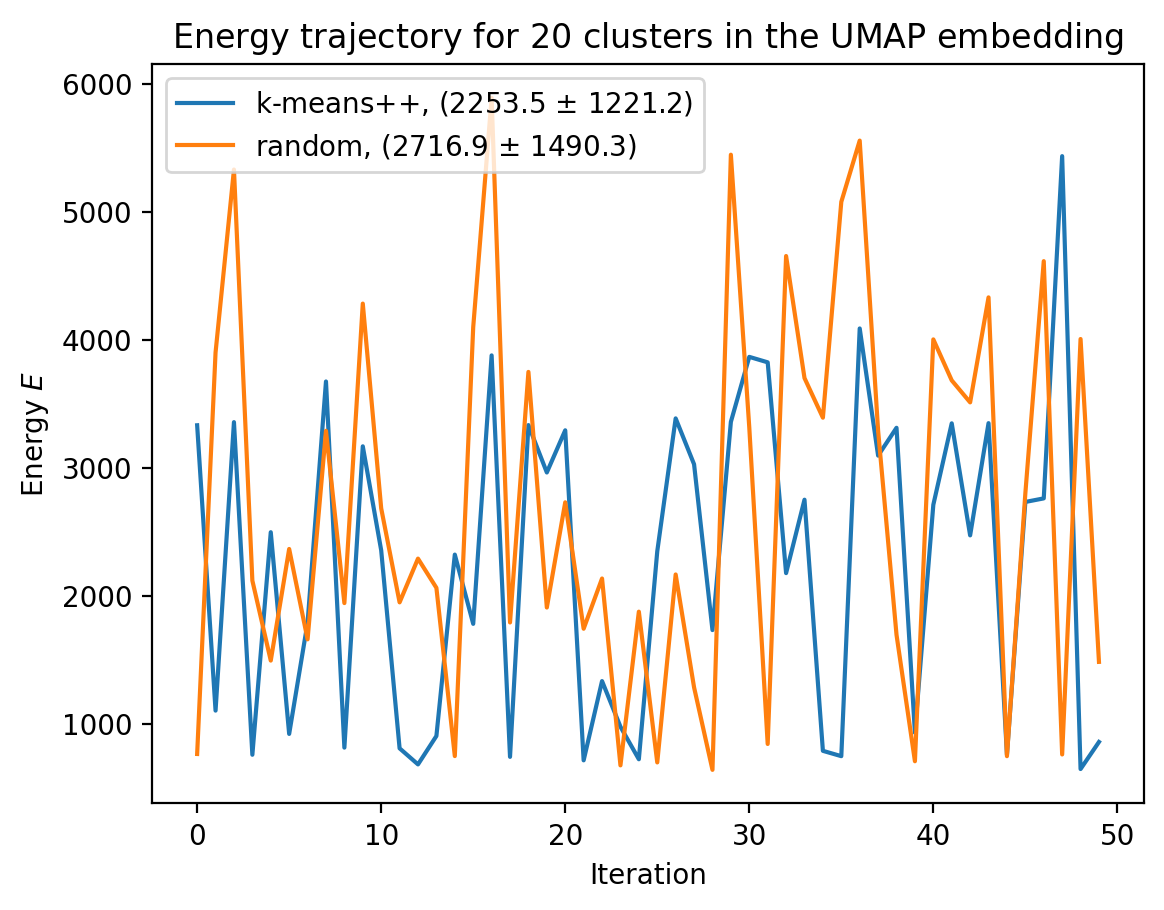

In [50]:
steps = 50
for k in [3, 5, 10, 20]:
    plt.figure(dpi=200)
    plt.title(f'Energy trajectory for ${k}$ clusters in the UMAP embedding')
    plt.xlabel('Iteration')
    plt.ylabel('Energy $E$')
    for init in ['k-means++', 'random']:
        # TODO: for the given k and init, run k-means 20 times or more (using the kmeans function above)
        #       and plot the resulting energy trajectores
        ergs = kmeans(features.T, k, steps)
        plt.plot(np.arange(steps), ergs, label = f"{init}, ({round(np.mean(ergs), 1)} $\pm$ {round(np.std(ergs), 1)})")
        plt.legend()
    plt.show()

The $2D$ <code>UMAP</code> embeddings generally cluster better (lower energy), probably as they do not suffer from the curse of dimensionality. The $L_2$ norm in the energy function works much better in 2 dimensions than in higher ones since the ratio between the farthest and nearest points apporoach unity in high dimensions  (<a href="https://bib.dbvis.de/uploadedFiles/155.pdf">On the Surprising Behavior of Distance Metrics
in High Dimensional Space</a>).